# Wrangle NHANES

Pulling raw NHANES dietary recall data for 2017-2020 and 2021-2023 waves, joining with FPED, demographics, and eventually calculating HEI scores to make our nice clean single DF to work with for clustering and analyses.

## Set Working Directory

When you open a notebook, the default working directory will be the folder that notebook is in. We want it to be the top (root) directory of the project, `ds1_nhanes`.

First, we need to mount our Google Drive, which contains the `ds1_nhanes` folder. The following chunk will mount the drive (if in Google Colab) and set the working directory to the root of the project folder. Note that this code chunk should be at the top of every notebook.

In [311]:
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

c:\Users\cdonov12\local\repos\ds1_nhanes


Bingo bongo, we're good to go.

## Load Libraries and Data

In [312]:
import pandas as pd
import numpy as np
import re

The DR1IFF_L and DR2IFF_L datasets include daily food intake over two days for respondents identified by the SEQN or respondent sequence identifier. The surveys were conducted in waves and we aim to combine two waves of data survey responses from 2017-2020 and 2021-2023. Given the size of these datasets we tried to pull only the columns that are relevant for our analysis are read for both days and both years, however, usecols does not work on .XPT files.

In [313]:
# Read in the four datasets with specified columns
dr1_17 = pd.read_sas('data/raw/nhanes_2017_2020/P_DR1IFF.xpt')
dr2_17 = pd.read_sas('data/raw/nhanes_2017_2020/P_DR2IFF.xpt')
dr1_21 = pd.read_sas('data/raw/nhanes_2021_2023/DR1IFF_L.xpt')
dr2_21 = pd.read_sas('data/raw/nhanes_2021_2023/DR2IFF_L.xpt')

# Create a list of all the datasets
datasets = [dr1_21, dr2_21, dr1_17, dr2_17]

# Define the relevant columns for this analysis
relevant_cols = ['SEQN', # response_sequence, unique identifier for each respondent
                 'WTDR2D', # weight_day_2_dietary, the weighting factor given to
                 # the second day depending on how many days the respondents reported
                 'WTDR2DPP', # different name in 2017 - 2020 data
                 'DR1IGRMS', # grams, total grams of food consumed, labeled DR1GRMS or DR2GRMS
                 # based on which day it was reported
                 'DR2IGRMS', # labeled DR1GRMS or DR2GRMS based on which day it was reported
                 'DR1IFDCD', # usda_food_code, food identifier
                 'DR2IFDCD'] # labeled DR1GRMS or DR2GRMS based on which day it was reported
for dataset in datasets:
  dataset.drop(columns=[col for col in dataset.columns if col not in relevant_cols], inplace=True)

#Look up what columns are relevant and load only what is relevant, check class notes - LB
print(dr1_21.info())
print(dr2_21.info())
print(dr1_17.info())
print(dr2_17.info())
dr1_21.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      100116 non-null  float64
 1   WTDR2D    100116 non-null  float64
 2   DR1IFDCD  100116 non-null  float64
 3   DR1IGRMS  99787 non-null   float64
dtypes: float64(4)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88032 entries, 0 to 88031
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      88032 non-null  float64
 1   WTDR2D    88032 non-null  float64
 2   DR2IFDCD  88032 non-null  float64
 3   DR2IGRMS  87778 non-null  float64
dtypes: float64(4)
memory usage: 2.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183910 entries, 0 to 183909
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEQN      183910 non-nu

,SEQN,WTDR2D,DR1IFDCD,DR1IGRMS
0,130378.0,70554.222162,94000100.0,120.0
1,130378.0,70554.222162,94000100.0,120.0
2,130378.0,70554.222162,92101000.0,300.0
3,130378.0,70554.222162,94000100.0,240.0
4,130378.0,70554.222162,83102000.0,4.9


## Explore Dietary Recall Data

Compare the dimensions of the df with the number of unique SEQN numbers (respondent ids)

In [314]:
# Compare rows to unique respondent IDs
# first get number of rows
rows = dr1_21.shape[0]
unique_seqns = dr1_21['SEQN'].nunique()
print(f"{rows} rows and {unique_seqns} unique SEQN numbers in DR1.")

100116 rows and 6751 unique SEQN numbers in DR1.


There are far more rows than unique respondents. This is because for each respondent, there is one row for each individual food they consumed.

Check out how many unique food codes there are:

In [315]:
n_codes = dr1_21['DR1IFDCD'].nunique()
print(f"There are {n_codes} unique food codes")

There are 3987 unique food codes


In [316]:
# Check SEQNs between dr1 and dr2

diff = set(dr1_17['SEQN']).difference(dr2_17['SEQN'])
print(f"{len(diff)} SEQNs missing from DR2 that were in DR1 in the 2017 - 2020 wave")
diff2 = set(dr2_17['SEQN']).difference(dr1_17['SEQN'])
print(f"{len(diff2)} SEQNs missing from DR1 that were in DR2 in the 2017 - 2020 wave")

diff = set(dr1_21['SEQN']).difference(dr2_21['SEQN'])
print(f"{len(diff)} SEQNs missing from DR2 that were in DR1 in the 2021 - 2023 wave")
diff2 = set(dr2_21['SEQN']).difference(dr1_21['SEQN'])
print(f"{len(diff2)} SEQNs missing from DR1 that were in DR2 in the 2021 - 2023 wave")



1804 SEQNs missing from DR2 that were in DR1 in the 2017 - 2020 wave
2 SEQNs missing from DR1 that were in DR2 in the 2017 - 2020 wave
873 SEQNs missing from DR2 that were in DR1 in the 2021 - 2023 wave
1 SEQNs missing from DR1 that were in DR2 in the 2021 - 2023 wave


For the 2017 - 2020 wave, there are 1804 respondants for day 1 that did not report in day 2, and two respondent who reported in day 2 but not day 1.

For the 2021 - 2023 wave, there are 873 respondants for day 1 that did not report in day 2, and one respondent who reported in day 2 but not day 1.  people when we join.

The two-day weights (WTDR2) was adjusted based on the day 1 weights (WTDR1) and further adjusting for additional non-response for the second recall, so we will drop the respondents that only respond in both days.


In [317]:
# JEANNINE ADDED
# Get a list of the missing SEQNs

# 2017-2020 wave
missing_from_dr2_17 = list(set(dr1_17['SEQN']).difference(dr2_17['SEQN']))
missing_from_dr1_17 = list(set(dr2_17['SEQN']).difference(dr1_17['SEQN']))

# 2021-2023 wave
missing_from_dr2_21 = list(set(dr1_21['SEQN']).difference(dr2_21['SEQN']))
missing_from_dr1_21 = list(set(dr2_21['SEQN']).difference(dr1_21['SEQN']))

# Print the lists of missing SEQN values
print("SEQNs missing from DR2 that were in DR1 in the 2017 - 2020 wave:", missing_from_dr2_17)
print("SEQNs missing from DR1 that were in DR2 in the 2017 - 2020 wave:", missing_from_dr1_17)
print("SEQNs missing from DR2 that were in DR1 in the 2021 - 2023 wave:", missing_from_dr2_21)
print("SEQNs missing from DR1 that were in DR2 in the 2021 - 2023 wave:", missing_from_dr1_21)

SEQNs missing from DR2 that were in DR1 in the 2017 - 2020 wave: [122881.0, 122886.0, 114695.0, 122889.0, 122894.0, 122904.0, 114713.0, 114715.0, 114718.0, 122910.0, 114725.0, 114726.0, 122919.0, 114730.0, 122926.0, 122934.0, 122944.0, 122946.0, 114757.0, 122951.0, 122956.0, 114781.0, 114793.0, 114795.0, 122990.0, 123009.0, 114828.0, 123021.0, 114845.0, 123037.0, 114848.0, 114850.0, 114851.0, 123043.0, 123048.0, 123053.0, 114864.0, 123056.0, 114871.0, 114872.0, 123065.0, 114877.0, 114890.0, 114893.0, 123098.0, 123101.0, 123104.0, 123107.0, 114923.0, 123116.0, 114926.0, 114932.0, 123125.0, 123129.0, 123130.0, 114944.0, 114951.0, 114954.0, 123150.0, 114964.0, 123161.0, 114972.0, 123172.0, 123174.0, 114983.0, 123177.0, 114999.0, 115001.0, 123201.0, 115013.0, 115014.0, 123206.0, 123208.0, 123213.0, 123219.0, 123223.0, 123224.0, 115036.0, 123229.0, 123231.0, 115040.0, 115045.0, 123242.0, 123248.0, 115057.0, 115058.0, 123249.0, 115065.0, 123258.0, 115070.0, 123263.0, 123264.0, 123271.0, 1150

## Join with FPED

Join FPED to each of the four DR datasets. We have to do this and aggregate within each DR before we combine the DRs together, otherwise we get cartesian merges.

In [318]:
fped = pd.read_csv('data/miscellany/FPED_1720.csv')
fped.columns = fped.columns.str.lower()
fped.columns = fped.columns.str.replace(" ", "_")

fped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   foodcode                   7444 non-null   int64  
 1   description                7444 non-null   object 
 2   f_total_(cup_eq)           7444 non-null   float64
 3   f_citmlb_(cup_eq)          7444 non-null   float64
 4   f_other_(cup_eq)           7444 non-null   float64
 5   f_juice_(cup_eq)           7444 non-null   float64
 6   v_total_(cup_eq)           7444 non-null   float64
 7   v_drkgr_(cup_eq)           7444 non-null   float64
 8   v_redor_total_(cup_eq)     7444 non-null   float64
 9   v_redor_tomato_(cup_eq)    7444 non-null   float64
 10  v_redor_other_(cup_eq)     7444 non-null   float64
 11  v_starchy_total_(cup_eq)   7444 non-null   float64
 12  v_starchy_potato_(cup_eq)  7444 non-null   float64
 13  v_starchy_other_(cup_eq)   7444 non-null   float

Rename columns in DR datasets that are not consistent (FDCD, GRMS, and 2 day weights). This will make it easier map over the list of all datasets when we aggregate

In [319]:
# Function to rename columns across all datasets
# These are the ones we care about that differ between DR dataset
def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if re.search(r'FDCD$', col):
            new_columns[col] = 'food_code'
        elif re.search(r'GRMS$', col):
            new_columns[col] = 'grams'
        elif re.search(r'^WTDR2', col):
            new_columns[col] = 'weight_2d'
        else:
            new_columns[col] = col

    df = df.rename(columns=new_columns)
    return df

# Rename columns in each dataset
datasets_renamed = list(map(rename_columns, datasets))

print("\nRenamed Datasets:\n")
list(map(lambda df: df.info(), datasets_renamed))



Renamed Datasets:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SEQN       100116 non-null  float64
 1   weight_2d  100116 non-null  float64
 2   food_code  100116 non-null  float64
 3   grams      99787 non-null   float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88032 entries, 0 to 88031
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       88032 non-null  float64
 1   weight_2d  88032 non-null  float64
 2   food_code  88032 non-null  float64
 3   grams      87778 non-null  float64
dtypes: float64(4)
memory usage: 2.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183910 entries, 0 to 183909
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0  

[None, None, None, None]

Merge each DR with FPED

In [320]:
# Map over our list of datasets and merge each out with FPED
def merge_with_fped(df):
    return df.merge(fped, left_on='food_code', right_on='foodcode', how='left')

dfs_fped = list(map(merge_with_fped, datasets_renamed))

print("\nDatasets with FPED:\n")
list(map(lambda df: df.info(), dfs_fped))


Datasets with FPED:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100116 entries, 0 to 100115
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SEQN                       100116 non-null  float64
 1   weight_2d                  100116 non-null  float64
 2   food_code                  100116 non-null  float64
 3   grams                      99787 non-null   float64
 4   foodcode                   99788 non-null   float64
 5   description                99788 non-null   object 
 6   f_total_(cup_eq)           99788 non-null   float64
 7   f_citmlb_(cup_eq)          99788 non-null   float64
 8   f_other_(cup_eq)           99788 non-null   float64
 9   f_juice_(cup_eq)           99788 non-null   float64
 10  v_total_(cup_eq)           99788 non-null   float64
 11  v_drkgr_(cup_eq)           99788 non-null   float64
 12  v_redor_total_(cup_eq)     99788 non-null   float64
 13  v_redor

[None, None, None, None]

## Combine Datasets

Now we can concat DR1 and DR2 together for each wave

In [321]:
# Combine first and second DF to make a df for 2021-2023
df_21 = pd.concat([dfs_fped[0], dfs_fped[1]], ignore_index=True)
df_21.info()

# Combine second and third DF to make df for 2017-2020
df_17 = pd.concat([dfs_fped[2], dfs_fped[3]], ignore_index=True)
df_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188148 entries, 0 to 188147
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SEQN                       188148 non-null  float64
 1   weight_2d                  188148 non-null  float64
 2   food_code                  188148 non-null  float64
 3   grams                      187565 non-null  float64
 4   foodcode                   187510 non-null  float64
 5   description                187510 non-null  object 
 6   f_total_(cup_eq)           187510 non-null  float64
 7   f_citmlb_(cup_eq)          187510 non-null  float64
 8   f_other_(cup_eq)           187510 non-null  float64
 9   f_juice_(cup_eq)           187510 non-null  float64
 10  v_total_(cup_eq)           187510 non-null  float64
 11  v_drkgr_(cup_eq)           187510 non-null  float64
 12  v_redor_total_(cup_eq)     187510 non-null  float64
 13  v_redor_tomato_(cup_eq)    18

Get food group totals for each food code for each person. Take grams, divide by 100, then multiply by every food group category.

In [322]:
# Put them back into a list
waves = [df_17, df_21]

def get_food_group_totals(df):
    df.loc[:, 'f_total_(cup_eq)':'a_drinks_(no._of_drinks)'].multiply(df['grams']/100, axis=0)
    return df

waves_fped = list(map(
    get_food_group_totals,
    waves
))

waves_fped[0].head()

,SEQN,weight_2d,food_code,grams,foodcode,description,f_total_(cup_eq),f_citmlb_(cup_eq),f_other_(cup_eq),f_juice_(cup_eq),...,pf_nutsds_(oz_eq),pf_legumes_(oz_eq),d_total_(cup_eq),d_milk_(cup_eq),d_yogurt_(cup_eq),d_cheese_(cup_eq),oils_(grams),solid_fats_(grams),add_sugars_(tsp_eq),a_drinks_(no._of_drinks)
0,109263.0,17808.067666,28320300.0,199.5,28320300,"Pork with vegetable excluding carrots, broccol...",0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,0.81,0.14,0.00,0.0
1,109263.0,17808.067666,91746110.0,20.0,91746110,"Chocolate candy, candy shell with nuts",0.0,0.0,0.0,0.0,...,1.99,0.0,0.05,0.03,0.0,0.0,5.09,16.02,11.52,0.0
2,109263.0,17808.067666,58106210.0,238.0,58106210,"Pizza, cheese, from restaurant or fast food, N...",0.0,0.0,0.0,0.0,...,0.00,0.0,0.70,0.00,0.0,0.7,3.54,5.01,0.26,0.0
3,109263.0,17808.067666,64104010.0,209.0,64104010,"Apple juice, 100%",0.4,0.0,0.0,0.4,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0
4,109263.0,17808.067666,11710801.0,124.0,11710801,"Infant formula, ready-to-feed (PediaSure)",0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0


Group by SEQN and aggregate FPED variables

In [323]:
## Grouping by SEQN within each DR dataset
# Set aggregation functions so we don't have to do them all manually
# Everything except food code and description in FPED should be summedf
cols_to_sum = fped.columns[2:]

# Set aggregation functions
aggs = {col: 'sum' for col in cols_to_sum}
aggs['SEQN'] = 'first'
aggs['weight_2d'] = 'unique'
aggs['grams'] = 'sum'

# Aggregate each dataset
waves_grouped = list(map(
    lambda df:
        df.groupby('SEQN').agg(aggs),
    waves_fped
))

waves_grouped[0].head()

,f_total_(cup_eq),f_citmlb_(cup_eq),f_other_(cup_eq),f_juice_(cup_eq),v_total_(cup_eq),v_drkgr_(cup_eq),v_redor_total_(cup_eq),v_redor_tomato_(cup_eq),v_redor_other_(cup_eq),v_starchy_total_(cup_eq),...,d_milk_(cup_eq),d_yogurt_(cup_eq),d_cheese_(cup_eq),oils_(grams),solid_fats_(grams),add_sugars_(tsp_eq),a_drinks_(no._of_drinks),SEQN,weight_2d,grams
SEQN,,,,,,,,,,,,,,,,,,,,,
109263.0,1.60,0.00,0.00,1.60,0.36,0.00,0.15,0.15,0.00,0.00,...,0.26,0.00,3.19,25.41,82.28,49.04,0.0,109263.0,[17808.067666],2827.75
109264.0,0.00,0.00,0.00,0.00,4.17,0.86,1.03,0.66,0.37,0.00,...,0.12,0.00,3.09,119.77,107.89,43.70,0.0,109264.0,[7253.761719],4177.01
109265.0,2.28,0.67,0.41,1.20,3.34,0.21,0.38,0.16,0.22,1.93,...,1.43,0.00,2.35,104.86,168.54,45.45,0.0,109265.0,[35612.007356],4081.76
109266.0,0.87,0.70,0.17,0.00,3.98,0.07,0.60,0.16,0.44,2.48,...,0.20,0.26,2.44,82.41,40.39,14.80,0.0,109266.0,[5988.203624],9866.51
109269.0,0.04,0.00,0.00,0.04,1.85,0.00,0.10,0.10,0.00,1.75,...,0.25,0.00,2.99,175.65,87.97,18.82,0.0,109269.0,[18231.925894],1906.30


Now we are down to 1 row per SEQN per wave, including both days of dietary recall.

Finally we can concat both waves into a single df and divide 2day weights by 2


In [324]:
# Combine waves
df = pd.concat(waves_grouped, ignore_index=True)

# Divide 2day weights by 2 since we are combining two waves
df['weight_2d'] = df['weight_2d'] / 2

# Rearrange columns by bringing important ones to front
# Leaving in grams just as a check
front_cols = ['SEQN', 'weight_2d', 'grams']
cols = front_cols + [col for col in df.columns if col not in front_cols]
df = df[cols]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       19386 non-null  float64
 1   weight_2d                  19386 non-null  object 
 2   grams                      19386 non-null  float64
 3   f_total_(cup_eq)           19386 non-null  float64
 4   f_citmlb_(cup_eq)          19386 non-null  float64
 5   f_other_(cup_eq)           19386 non-null  float64
 6   f_juice_(cup_eq)           19386 non-null  float64
 7   v_total_(cup_eq)           19386 non-null  float64
 8   v_drkgr_(cup_eq)           19386 non-null  float64
 9   v_redor_total_(cup_eq)     19386 non-null  float64
 10  v_redor_tomato_(cup_eq)    19386 non-null  float64
 11  v_redor_other_(cup_eq)     19386 non-null  float64
 12  v_starchy_total_(cup_eq)   19386 non-null  float64
 13  v_starchy_potato_(cup_eq)  19386 non-null  flo

In [325]:
# Make the SEQN column an integer and weight_2d a float with two decimal places

df['SEQN'] = df['SEQN'].astype(int)

df['weight_2d'] = df['weight_2d'].astype(float)
df['weight_2d'] = df['weight_2d'].round(2)

df

,SEQN,weight_2d,grams,f_total_(cup_eq),f_citmlb_(cup_eq),f_other_(cup_eq),f_juice_(cup_eq),v_total_(cup_eq),v_drkgr_(cup_eq),v_redor_total_(cup_eq),...,pf_nutsds_(oz_eq),pf_legumes_(oz_eq),d_total_(cup_eq),d_milk_(cup_eq),d_yogurt_(cup_eq),d_cheese_(cup_eq),oils_(grams),solid_fats_(grams),add_sugars_(tsp_eq),a_drinks_(no._of_drinks)
0,109263,8904.03,2827.75,1.60,0.00,0.00,1.60,0.36,0.00,0.15,...,1.99,0.00,3.47,0.26,0.00,3.19,25.41,82.28,49.04,0.00
1,109264,3626.88,4177.01,0.00,0.00,0.00,0.00,4.17,0.86,1.03,...,0.52,0.00,3.26,0.12,0.00,3.09,119.77,107.89,43.70,0.00
2,109265,17806.00,4081.76,2.28,0.67,0.41,1.20,3.34,0.21,0.38,...,0.00,0.00,3.82,1.43,0.00,2.35,104.86,168.54,45.45,0.00
3,109266,2994.10,9866.51,0.87,0.70,0.17,0.00,3.98,0.07,0.60,...,0.44,0.46,5.40,0.20,0.26,2.44,82.41,40.39,14.80,0.00
4,109269,9115.96,1906.30,0.04,0.00,0.00,0.04,1.85,0.00,0.10,...,0.00,0.00,3.31,0.25,0.00,2.99,175.65,87.97,18.82,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19381,142303,24470.59,2969.85,1.07,0.00,0.67,0.40,0.67,0.00,0.12,...,0.00,0.71,1.07,0.00,0.00,1.07,41.42,42.53,26.01,0.00
19382,142304,18983.82,1984.75,0.81,0.00,0.00,0.81,0.75,0.00,0.74,...,0.00,0.00,1.25,0.04,0.00,1.21,91.13,59.02,10.64,0.00
19383,142307,35129.58,4994.00,0.72,0.00,0.67,0.05,0.91,0.32,0.18,...,0.14,0.00,1.30,0.29,0.39,0.47,75.74,40.35,50.85,0.00
19384,142309,44695.97,3649.05,0.00,0.00,0.00,0.00,2.09,0.00,0.68,...,0.71,0.00,1.42,0.00,0.00,1.42,24.55,20.77,8.88,0.00


This is hopefully a nice clean DF with one row per SEQN, both DR days, and two waves lumped together.

## Add Demographics

The NHANES dataset includes demographics for each respondent. The following steps merge key demographics with each respondent id number SEQN.

Load demographic data as xpt:

In [326]:
demos_17 = pd.read_sas('data/raw/nhanes_2017_2020/P_DEMO.xpt')
demos_21 = pd.read_sas('data/raw/nhanes_2021_2023/DEMO_L.xpt')

demos_17.info()
demos_21.info()

# combine into a single dataset
demos = pd.concat([demos_17, demos_21], ignore_index=True)
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15560 entries, 0 to 15559
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      15560 non-null  float64
 1   SDDSRVYR  15560 non-null  float64
 2   RIDSTATR  15560 non-null  float64
 3   RIAGENDR  15560 non-null  float64
 4   RIDAGEYR  15560 non-null  float64
 5   RIDAGEMN  987 non-null    float64
 6   RIDRETH1  15560 non-null  float64
 7   RIDRETH3  15560 non-null  float64
 8   RIDEXMON  14300 non-null  float64
 9   DMDBORN4  15560 non-null  float64
 10  DMDYRUSZ  3028 non-null   float64
 11  DMDEDUC2  9232 non-null   float64
 12  DMDMARTZ  9232 non-null   float64
 13  RIDEXPRG  1874 non-null   float64
 14  SIALANG   15560 non-null  float64
 15  SIAPROXY  15560 non-null  float64
 16  SIAINTRP  15560 non-null  float64
 17  FIALANG   14481 non-null  float64
 18  FIAPROXY  14481 non-null  float64
 19  FIAINTRP  14481 non-null  float64
 20  MIALANG   11000 non-null  fl

Take the columns SEQN, age, gender, race, education, and ratio of family income to poverty:

In [327]:
demos = demos[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMPIR']]
# rename the demo columns
demos.columns = ['SEQN', 'gender', 'age', 'race', 'education', 'income_ratio']
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27493 entries, 0 to 27492
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEQN          27493 non-null  float64
 1   gender        27493 non-null  float64
 2   age           27493 non-null  float64
 3   race          27493 non-null  float64
 4   education     17026 non-null  float64
 5   income_ratio  23251 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


Merge demographics with our dietary intake data:

In [328]:
# check to see
diff = set(df['SEQN']).difference(demos['SEQN'])
print(f"{len(diff)} SEQNs missing from demographics that were in dietary intake")
diff2 = set(demos['SEQN']).difference(df['SEQN'])
print(f"{len(diff2)} SEQNs missing from dietary intake that were in demographics")

# Now join our demos with dietary intake data
df = df.merge(demos, on='SEQN', how='left')
df.info()

0 SEQNs missing from demographics that were in dietary intake
8107 SEQNs missing from dietary intake that were in demographics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       19386 non-null  int64  
 1   weight_2d                  19386 non-null  float64
 2   grams                      19386 non-null  float64
 3   f_total_(cup_eq)           19386 non-null  float64
 4   f_citmlb_(cup_eq)          19386 non-null  float64
 5   f_other_(cup_eq)           19386 non-null  float64
 6   f_juice_(cup_eq)           19386 non-null  float64
 7   v_total_(cup_eq)           19386 non-null  float64
 8   v_drkgr_(cup_eq)           19386 non-null  float64
 9   v_redor_total_(cup_eq)     19386 non-null  float64
 10  v_redor_tomato_(cup_eq)    19386 non-null  float64
 11  v_redor_other_(cup_eq)     1938

Recode demographic variables. Coding schemes are available at the NHANES website in the documentation beside each dataset. We are splitting the income to poverty ratio into quartiles.

In [329]:
# Gender
df['gender'] = df['gender'].apply(lambda x: ('Female' if x == 2 else 'Male'))

# Education
df['education'] = df['education'].apply(
  lambda x: (
    'Less than 9th grade' if x == 1
    else '9th to 11th grade' if x == 2
    else 'High school/GED' if x == 3
    else 'Some college or AA' if x == 4
    else 'College graduate or above' if x == 5
    else "Don\'t know"
  )
)

# Race
df['race'] = df['race'].apply(
  lambda x: (
    'Mexican American' if x == 1
    else 'Other Hispanic' if x == 2
    else 'White' if x == 3
    else 'Black' if x == 4
    else 'Asian' if x == 5
    else 'Other or Multi'
  )
)

# Income to poverty ratio
df['income_ratio_qs'] = pd.qcut(
  x=df['income_ratio'],
  q=5,
  duplicates='drop',
  labels=['Lowest', 'Low', 'Medium', 'High', 'Highest']
)
df.head()

,SEQN,weight_2d,grams,f_total_(cup_eq),f_citmlb_(cup_eq),f_other_(cup_eq),f_juice_(cup_eq),v_total_(cup_eq),v_drkgr_(cup_eq),v_redor_total_(cup_eq),...,oils_(grams),solid_fats_(grams),add_sugars_(tsp_eq),a_drinks_(no._of_drinks),gender,age,race,education,income_ratio,income_ratio_qs
0,109263,8904.03,2827.75,1.60,0.00,0.00,1.60,0.36,0.00,0.15,...,25.41,82.28,49.04,0.0,Male,2.0,Other or Multi,Don't know,4.66,High
1,109264,3626.88,4177.01,0.00,0.00,0.00,0.00,4.17,0.86,1.03,...,119.77,107.89,43.70,0.0,Female,13.0,Mexican American,Don't know,0.83,Lowest
2,109265,17806.00,4081.76,2.28,0.67,0.41,1.20,3.34,0.21,0.38,...,104.86,168.54,45.45,0.0,Male,2.0,White,Don't know,3.06,High
3,109266,2994.10,9866.51,0.87,0.70,0.17,0.00,3.98,0.07,0.60,...,82.41,40.39,14.80,0.0,Female,29.0,Other or Multi,College graduate or above,5.00,Highest
4,109269,9115.96,1906.30,0.04,0.00,0.00,0.04,1.85,0.00,0.10,...,175.65,87.97,18.82,0.0,Male,2.0,Other Hispanic,Don't know,0.96,Low


In [330]:
# JEANNINE ADDED
# From the lists of missing SEQN values as described determined above
# missing_from_dr2_17, missing_from_dr1_17, missing_from_dr2_21, missing_from_dr1_21

# Create a DataFrame containing only the missing SEQN values
missing_seqn_df = demos[demos['SEQN'].isin(missing_from_dr2_17 + missing_from_dr1_17 + missing_from_dr2_21 + missing_from_dr1_21)]

# Display the demographic information of the missing SEQN values
print(missing_seqn_df)

           SEQN  gender   age  race  education  income_ratio
17     109280.0     2.0   2.0   1.0        NaN          1.71
33     109296.0     1.0  10.0   4.0        NaN          2.34
43     109306.0     1.0   2.0   3.0        NaN          1.02
44     109307.0     1.0  47.0   6.0        1.0          1.38
46     109309.0     1.0   5.0   2.0        NaN          0.87
...         ...     ...   ...   ...        ...           ...
27444  142262.0     2.0   8.0   3.0        NaN          0.91
27456  142274.0     2.0   7.0   3.0        NaN          0.81
27462  142280.0     2.0  23.0   7.0        4.0          1.40
27468  142286.0     1.0  70.0   3.0        3.0          2.87
27482  142300.0     2.0  46.0   1.0        3.0          0.68

[2680 rows x 6 columns]


## Calculate PBP Consumption

Get column names for consumption of protein/fats from PBPs (legumes, nuts and seeds, and soy). Then add them together to get total ounces of PBP consumption per person. And also calculating PBP consumption as a proportion of total protein consumption.

In [331]:
# Keywords we will use to find column names
keywords = ['pf_legumes', 'pf_nutsds', 'pf_soy']
pbp_columns = [col for col in df.columns if any(keyword in col for keyword in keywords)]

# Condition: Any of the selected columns has a value greater than 1
# df['has_pbp'] = (df[pbp_columns] > 1).any(axis=1)
# print(df.head())

# Check that this worked
# df[df['has_pbp'] == True][pbp_columns + ['has_pbp']].head(10)

# Sum the total oz equivalents of pbp in a new column
df['oz_pbp'] = df[pbp_columns].sum(axis=1)

# Check that this worked - oz from pbp should be sum of the three pbp cols
print(df[['SEQN', 'oz_pbp'] + pbp_columns].head())

     SEQN  oz_pbp  pf_soy_(oz_eq)  pf_nutsds_(oz_eq)  pf_legumes_(oz_eq)
0  109263    1.99            0.00               1.99                0.00
1  109264    0.52            0.00               0.52                0.00
2  109265    0.04            0.04               0.00                0.00
3  109266    1.10            0.20               0.44                0.46
4  109269    0.00            0.00               0.00                0.00


Check how many people consumed 0 protein total (excludes legumes), or mps total (meat, poultry, seafood)

In [332]:
print(f"{df[df['pf_total_(oz_eq)'] == 0].shape[0]} \
people consumed no total protein (excluding legumes)")

print(f"{df[df['pf_mps_total_(oz_eq)'] == 0].shape[0]} \
people consumed no meat, poultry, seafood protein")

print(f"{df[df['pf_total_(oz_eq)'] + df['pf_legumes_(oz_eq)']== 0].shape[0]} \
people consumed no total protein OR legume protein")

554 people consumed no total protein (excluding legumes)
1220 people consumed no meat, poultry, seafood protein
509 people consumed no total protein OR legume protein


Note that the pf_total category excludes legumes, presumably because these are not the same quality as meat proteins? This is worth looking into more to see whether it is fair for us to make this comparison. We might be better off using the grams of protein from the NHANES survey instead?

Anyhow, if we want to get a proportion of ounces of PBP out of total proteins, we should compare PBPs to pf_total + pf_legumes

In [333]:
# Make our own total protein variable, adding total protein to legumes
df['pf_total_calc'] = df['pf_total_(oz_eq)'] + df['pf_legumes_(oz_eq)']
df['prop_pbp'] = np.where(
    df['pf_total_calc'] == 0,
    np.nan,
    df['oz_pbp'] / (df['pf_total_calc'])
)

print(df[['SEQN', 'oz_pbp', 'pf_total_(oz_eq)', 'prop_pbp']].head(10))

# Check how many NaNs there are in prop_pbp
print(f'\nThere are {df["prop_pbp"].isna().sum()} NaNs in prop_pbp')

     SEQN  oz_pbp  pf_total_(oz_eq)  prop_pbp
0  109263    1.99              8.22  0.242092
1  109264    0.52             14.02  0.037090
2  109265    0.04              9.67  0.004137
3  109266    1.10              2.59  0.360656
4  109269    0.00              2.51  0.000000
5  109270    0.00              9.23  0.000000
6  109271    0.04             17.21  0.002324
7  109272    0.00              0.00       NaN
8  109273    0.00              6.83  0.000000
9  109274    0.00              6.09  0.000000

There are 509 NaNs in prop_pbp


509 people are NA, which means the sum of their pf_total and pf_legumes was 0.

Let's check summary stats on the proportions and make sure they make sense

In [334]:
df['prop_pbp'].describe()

count    18877.000000
mean         0.248736
std          0.285101
min          0.000000
25%          0.000000
50%          0.134887
75%          0.444676
max          1.000000
Name: prop_pbp, dtype: float64

This is capping out at 1, which is perfect.

## Explore Missingness

### Check missing income by race and education

In [335]:
df_demos = df[['gender', 'age', 'education', 'race', 'income_ratio', 'weight_2d']]
df_demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        19386 non-null  object 
 1   age           19386 non-null  float64
 2   education     19386 non-null  object 
 3   race          19386 non-null  object 
 4   income_ratio  17129 non-null  float64
 5   weight_2d     19386 non-null  float64
dtypes: float64(3), object(3)
memory usage: 908.8+ KB


In [336]:
import numpy as np
print(df_demos.groupby('race')['income_ratio'].apply(lambda x: x.isna().mean()))
print(df_demos.groupby('education')['income_ratio'].apply(lambda x: x.isna().mean()))

race
Black               0.141255
Mexican American    0.147368
Other Hispanic      0.158818
Other or Multi      0.117293
White               0.084839
Name: income_ratio, dtype: float64
education
9th to 11th grade            0.136635
College graduate or above    0.107799
Don't know                   0.106936
High school/GED              0.127833
Less than 9th grade          0.217877
Some college or AA           0.108793
Name: income_ratio, dtype: float64


In [337]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    style="ticks",
    rc= {
      "axes.spines.right": False,
      "axes.spines.top": False,
      "figure.figsize": (6, 5)
    }
  )

C:\Users\cdonov12\AppData\Local\Temp\ipykernel_4260\1771036646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demos['missing_income'] = df_demos['income_ratio'].isna()


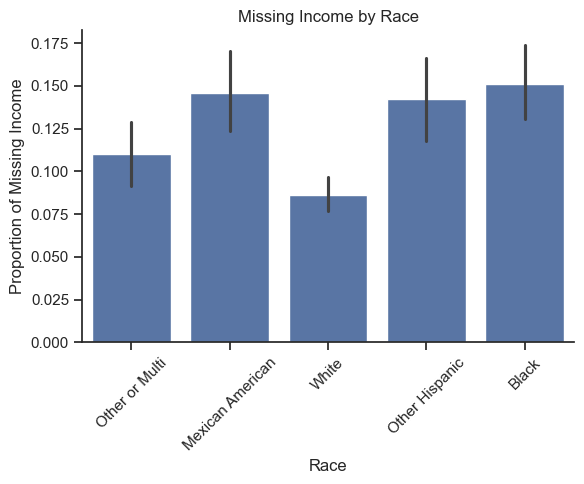

In [338]:
df_demos['missing_income'] = df_demos['income_ratio'].isna()

# Plot
sns.barplot(
    data=df_demos, 
    x='race', 
    y='missing_income',
    weights='weight_2d'
)
plt.title("Missing Income by Race")
plt.ylabel("Proportion of Missing Income")
plt.xlabel("Race")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

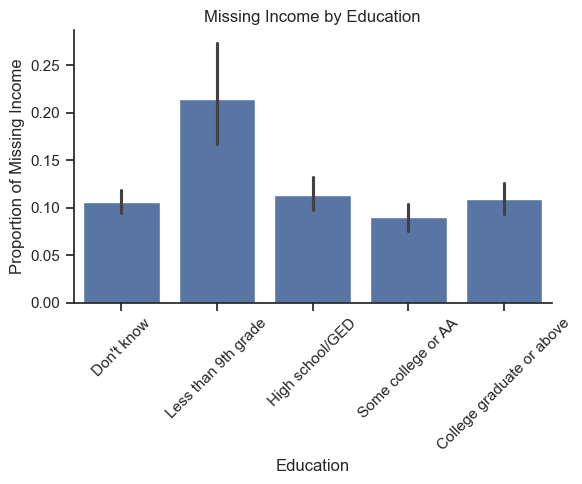

In [339]:
# Plot by education
sns.barplot(
    data=df_demos, 
    x='education', 
    y='missing_income',
    weights='weight_2d',
    order=[
        "Don't know",
        'Less than 9th grade',
        'High school/GED',
        'Some college or AA',
        'College graduate or above'
    ]
)
plt.title("Missing Income by Education")
plt.ylabel("Proportion of Missing Income")
plt.xlabel("Education")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Check Total Demographics

See if race counts are different between group that reported income and group that did not report income

In [340]:
df_demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          19386 non-null  object 
 1   age             19386 non-null  float64
 2   education       19386 non-null  object 
 3   race            19386 non-null  object 
 4   income_ratio    17129 non-null  float64
 5   weight_2d       19386 non-null  float64
 6   missing_income  19386 non-null  bool   
dtypes: bool(1), float64(3), object(3)
memory usage: 927.8+ KB


In [341]:
# Get prop missing for those who reported income
df_reported = df_demos[df_demos['missing_income'] == False]
weight_reported = df_reported['weight_2d'].sum()
print(f'Total weight: {weight_reported}')

# For people who reported income, get proportions of each race
race_props = df_reported[df_reported['missing_income'] == False].groupby('race')['weight_2d'].sum() / weight_reported
print(race_props)

Total weight: 289820639.76000005
race
Black               0.110606
Mexican American    0.089650
Other Hispanic      0.088720
Other or Multi      0.110625
White               0.600400
Name: weight_2d, dtype: float64


In [342]:
# Get prop missing for those who did NOT report income
df_mis = df_demos[df_demos['missing_income'] == True]
weight_mis = df_mis['weight_2d'].sum()
print(f'Total weight: {weight_mis}')

# For people who did NOT report income, get proportions of each race
race_props_mis = df_mis[df_mis['missing_income'] == True].groupby('race')['weight_2d'].sum() / weight_mis
print(race_props_mis)

Total weight: 34848221.96
race
Black               0.164024
Mexican American    0.127624
Other Hispanic      0.122470
Other or Multi      0.113695
White               0.472187
Name: weight_2d, dtype: float64


### Nature of Missingness

For some reason I cannot fathom, there is a test for MCAR in R from the naniar package, but no extant (and functioning) equivalent on the python side that I can tell. Here we will just use contingency table with chi square to see if there are differences in missingnes of income by race. This will serve as our test of MCAR I suppose.

In [343]:
from scipy.stats import chi2_contingency

# Chi square contingency table for whether prop missing varies by race
contingency = pd.crosstab(df_demos['race'], df_demos['missing_income'])
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)
print(f'\nChi sq test statistic: {round(chi2, 3)}, p-value:{"%.3f" % p}')
# Shows significant differences in demographics between reported income and not reported

missing_income    False  True 
race                          
Black              3599    592
Mexican American   1863    322
Other Hispanic     1679    317
Other or Multi     2491    331
White              7497    695

Chi sq test statistic: 159.797, p-value:0.000


Looks like missing data on income is related to race, so we can conclude that it is not MCAR.

We can also use a regression to see if there is a relationship between missingness on income and our other demographic variables. If other demos are significantly associated with missing income, it would be more evidence that it is MAR.

In [344]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Get dummy variables in the worst way
encoder = LabelEncoder()
df_demos.loc[:, 'race'] = encoder.fit_transform(df_demos['race'])
df_demos.loc[:, 'education'] = encoder.fit_transform(df_demos['education'])
df_demos.loc[:, 'age'] = encoder.fit_transform(df_demos['age'])
df_demos.loc[:, 'gender'] = encoder.fit_transform(df_demos['gender'])

X = df_demos[['race', 'education', 'age', 'gender']]
y = df_demos['missing_income']

# Force numeric for some reason
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Add constant manually because python hates humanity
X = sm.add_constant(X)

# Run model and get results
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.356147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         missing_income   No. Observations:                19386
Model:                          Logit   Df Residuals:                    19381
Method:                           MLE   Df Model:                            4
Date:                Fri, 04 Apr 2025   Pseudo R-squ.:                0.009987
Time:                        19:17:40   Log-Likelihood:                -6904.3
converged:                       True   LL-Null:                       -6973.9
Covariance Type:            nonrobust   LLR p-value:                 4.004e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8440      0.062    -29.601      0.000      -1.966      -1.722
race          -0.1553      0.

Missingness in income is related to both age and race. So definitely MAR. This means it is pretty fertile ground for imputation.

### Impute Income

Use missing forest to impute our income variable

In [ ]:
df = df_demos.copy()
print(df.info())
print(df['income_ratio'].head(25))

In [354]:
from missforest import MissForest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

categorical = ['gender', 'age', 'education', 'race', 'income_ratio']

# encoder = LabelEncoder()
# for column in df.columns:
#     df.loc[:, column] = encoder.fit_transform(df[column])

encoder = LabelEncoder(handle_unknown='ignore')
df.loc[:, 'race'] = encoder.fit_transform(df['race'])
df.loc[:, 'education'] = encoder.fit_transform(df['education'])
df.loc[:, 'age'] = encoder.fit_transform(df['age'])
df.loc[:, 'gender'] = encoder.fit_transform(df['gender'])
df.loc[:, 'income_ratio'] = encoder.fit_transform(df['income_ratio'])

print(df.head())
print(df['income_ratio'].head(25))

mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1), 
    rgr=RandomForestRegressor(n_jobs=-1), 
    categorical=categorical,
)
imputed_df = mf.fit_transform(df)

TypeError: LabelEncoder() takes no arguments

## Save Data

Let's save this as a csv so we can play around with it elsewhere:

In [ ]:
# One last check of data frame
df.info()

In [ ]:
df.to_csv('data/clean/nhanes_2017_2023_clean.csv', index=False)